# Project 10

## Parte 1. Priorizar hipótesis

Para priorizar hipótesis, se han evaluado los siguientes factores de cada una: impacto, confianza, esfuerzo y alcance. Se aplicarán los frameworks ICE y RICE para priorizar las hipótesis.

ICE = (impact * confidence) / effort

RICE = (reach * impact * confidence) / effort

RICE = reach * ICE

In [104]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import datetime as dt

A continuación se muestran algunas hipótesis.

In [105]:
# Read csv file
data = pd.read_csv('./hypotheses_us.csv', sep=';', header=0)
data.head(3)

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3


### Framework ICE

In [106]:
# Obtain ICE value
data['ICE'] = (data['Impact']*data['Confidence']) / data['Effort']
print(data[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False).head(3))

                                          Hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000


De manera que la hipótesis con más prioridad es "Launch a promotion that gives users discounts", después "Add two new channels for attracting traffic." y así sucesivamente. Ahora prioricemos mediante el framework RICE.

### Framework RICE

In [107]:
# Obtain RICE value
data['RICE'] = (data['Reach']*data['Impact']*data['Confidence']) / data['Effort']
print(data[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False).head(3))

                                          Hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0


De manera que la hipótesis con más prioridad es "Add a subscription form to all the main pages", después "Add product recommendation blocks to the store." y así sucesivamente.

Se puede ver que las prioridades de las hipótesis cambiaron, ya que con este ultimo framwork, el factor alcance eleva o disminuye la prioridad, es decir, RICE = reach * ICE.

## Parte 2. Análisis del test A/B

Se analizarán los resultados de una prueba A/B realizada previamente. Primero, se hara el análisis de los datos tomando en cuenta los outliers, después sin tomarlos en cuenta para determinar si tales outliers distorcionaron la prueba A/B. Se aplicará la prueba de Shapiro-Wilk para determinar si los datos tienen distribución normal, y también se aplicara la prueba de Wilcoxon-Mann-Whitney para determinar si existen diferencias significativas entre los grupos considerando los outliers. La prueba de Wilcoxon-Mann-Whitney se usa para validar proporciones en muestras sin ditribucion normal.

A continuación se importan los DataFrames y se eliminan duplicados respecto a las columnas 'date' y 'group'.

In [108]:
# Read DataFrame
orders = pd.read_csv('./orders_us.csv', sep=',', header=0)
# Change columns names
orders.columns = ['orderId','userId','date','revenue','group']

# Change column type
orders['date'] = pd.to_datetime(orders['date'])
orders['date'] = orders['date'].dt.strftime('%d/%m/%Y')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%d/%m/%Y'))

# Show DataFrame
orders.head(3)

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A


Se eliminarán usuarios que estan en ambos grupos.

In [109]:
# Obtain users in group A and B
duplicated_users = orders.groupby('userId')['group'].nunique()
duplicated_users = duplicated_users[duplicated_users > 1].index

# Delete users in both groups
orders = orders[~orders['userId'].isin(duplicated_users)]

In [110]:
# Read DataFrame
visits = pd.read_csv('./visits_us.csv', sep=',', header=0)
# Change columns names
visits.columns = ['date','group','visitors']

# Change column type
visits['date'] = pd.to_datetime(visits['date'])
visits['date'] = visits['date'].dt.strftime('%d/%m/%Y')
visits['date'] = visits['date'].map(lambda x: dt.datetime.strptime(x, '%d/%m/%Y'))

# Show DataFrame
visits.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


Para evitar el "peeking problem", se analizán gráficos de métricas acumuladas (el primer día están valores de las métricas para ese día, el segundo día están la suma de las métricas de los dos primeros días y así en adelante).

#### 1. Representa gráficamente el ingreso acumulado por grupo.

Se crea un DataFrame con valores únicos de parejas fecha-grupo.

In [111]:
# DataFrame with columns 'date' and 'group' (no duplicates)
datesGroups = orders[['date','group']].drop_duplicates()

Se obtienen las filas de la tabla orders donde la fecha es menor o igual que la fecha del elemento datesGroups y el grupo de prueba es el mismo que en datesGroups. Luego, agregaremos los valores y encontraremos la fecha máxima. También encontraremos el valor máximo para el grupo para tener la columna 'group' en la salida final. Encontramos el número de pedidos únicos e identificadores de usuarios y calculamos la suma de los tamaños de compra promedio.

Aplicaremos los métodos a cada fila del DataFrame (apply(axis=1)) y ordenaremos los resultados por las columnas 'date' y 'group'. Tras poner todo esto junto, se obtiene:

In [112]:
# Obtain metrics
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
    'date' : 'max', 'group' : 'max', 'orderId' : pd.Series.nunique, 'userId' : pd.Series.nunique, 'revenue' : 'sum'
}), axis=1).sort_values(by=['date','group'])

print(ordersAggregated.head(5))

          date group  orderId  userId  revenue
55  2019-08-01     A       23      19   2266.6
66  2019-08-01     B       17      17    967.2
175 2019-08-02     A       42      36   3734.9
173 2019-08-02     B       40      39   3535.3
291 2019-08-03     A       66      60   5550.1


Vamos a hacer algo parecido para obtener los datos diarios acumulados agregados sobre los visitantes

In [113]:
# Obtain metrics
visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({
    'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

print(visitorsAggregated.head(5))

          date group  visitors
55  2019-08-01     A       719
66  2019-08-01     B       713
175 2019-08-02     A      1338
173 2019-08-02     B      1294
291 2019-08-03     A      1845


Fusionamos las dos tablas en una y damos a sus columnas nombres descriptivos.

In [114]:
# Merge DataFrames
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
# Change column names
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   2266.6       719
1 2019-08-01     B      17      17    967.2       713
2 2019-08-02     A      42      36   3734.9      1338
3 2019-08-02     B      40      39   3535.3      1294
4 2019-08-03     A      66      60   5550.1      1845


Creemos gráficos de ingresos acumulados por día y grupo de prueba A/B.

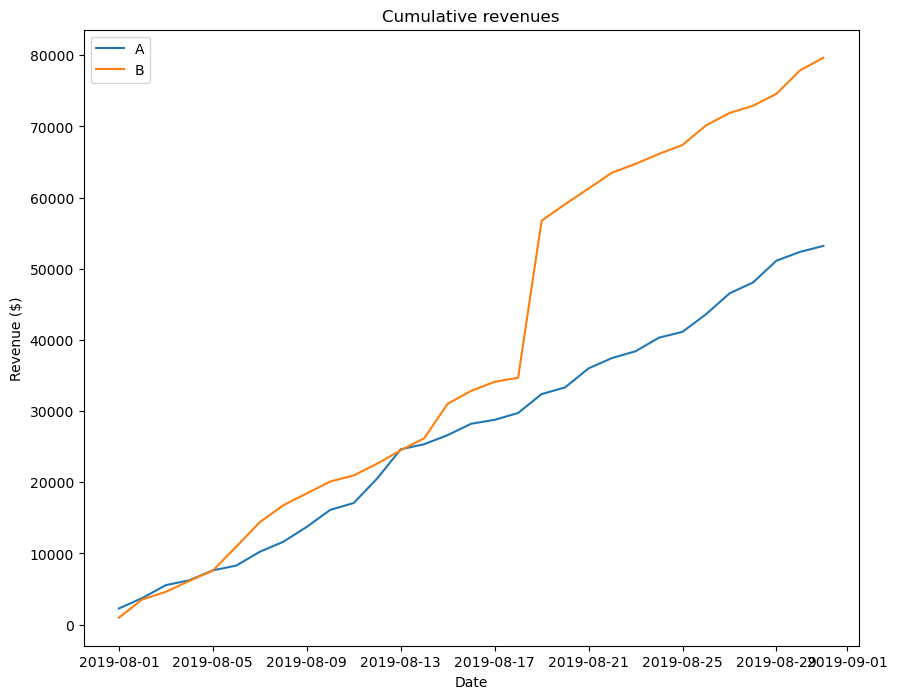

In [115]:
# Filter by group
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Line plot
plt.figure(figsize=(10,8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Cumulative revenues')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()

Los ingresos aumentan constantemente durante toda la prueba (buena señal). Hubo una compra atipica el dia 2019-08-19.

#### 2. Representa gráficamente el tamaño de pedido promedio acumulado por grupo.

Vamos a dividir los ingresos acumulados entre el número acumulado de pedidos:

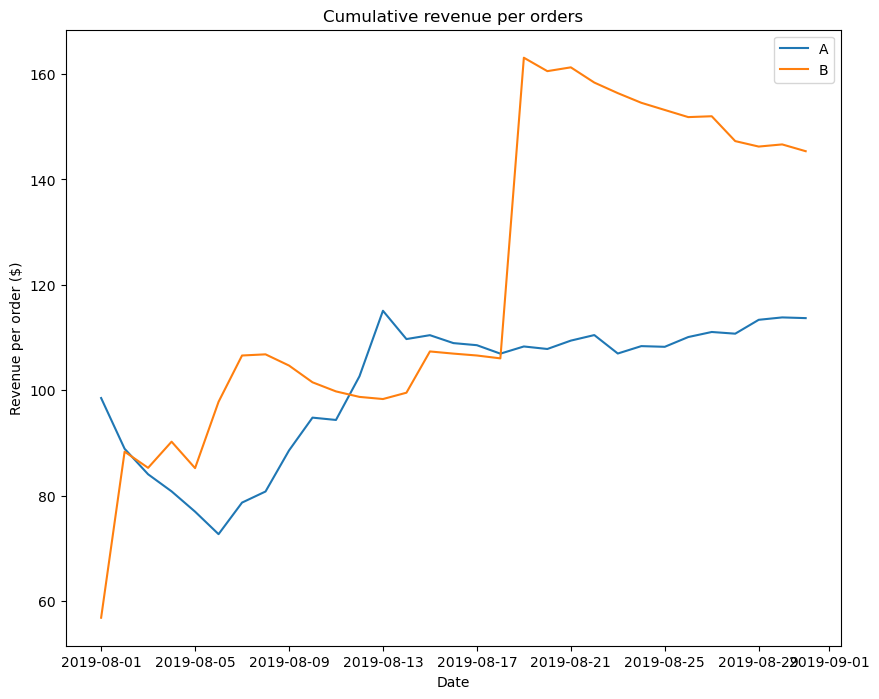

In [116]:
# Line plot
plt.figure(figsize=(10,8))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Cumulative revenue per orders')
plt.xlabel('Date')
plt.ylabel('Revenue per order ($)')
plt.legend()
plt.show()

Se observa que el tamaño de pedido promedio acumulado (para ambos grupos) se estabiliza y que el grupo B siempre estuvo encima del grupo A, como se mostrará en la gráfica de abajo.

**Nota:** Hubo una compra muy grande aproximadamente el dia 2019-08-19, eso alteró drásticamente la prueba. Más adelante se analirazán los datos quitando estos outliers.

#### 3. Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.

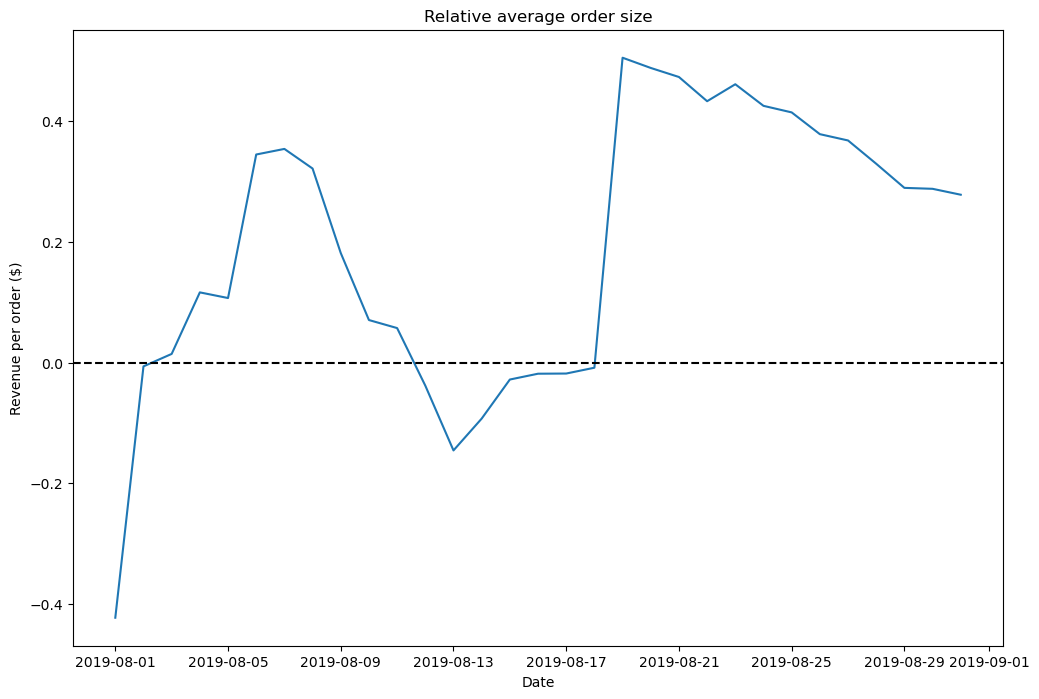

In [117]:
# Merge DataFrames
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(12,8))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Relative average order size')
plt.xlabel('Date')
plt.ylabel('Revenue per order ($)')
plt.show()

Por ahora no se puede determinar que el grupo B siempre estuvo por encima del grupo A, las compras atípicas afectan los resultados.

#### 4. Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia.

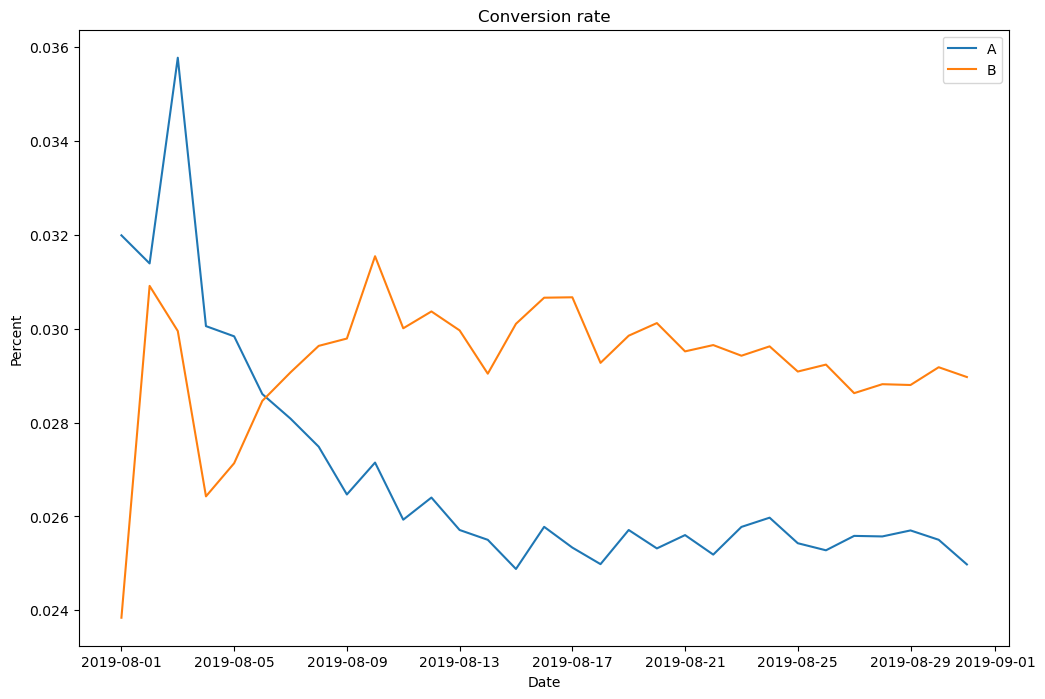

In [118]:
# Calculate cumulative convertion rate
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# Filter by group
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# Line plot
plt.figure(figsize=(12,8))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Conversion rate')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend()
plt.show()

Las tasas de conversión de ambos grupos flutua bastante al principio y en general durante todo el experimento.

**Conclusion:** Existen valores atípicos que perturbaron el experimento.

#### 5. Traza un gráfico de dispersión del número de pedidos por usuario.

In [119]:
# Group by 'userId' and count unique values of 'orderId'
ordersByUsers = orders.groupby('userId').agg({'orderId': 'nunique'}).reset_index()
# Change columns names
ordersByUsers.columns = ['userId', 'orders']

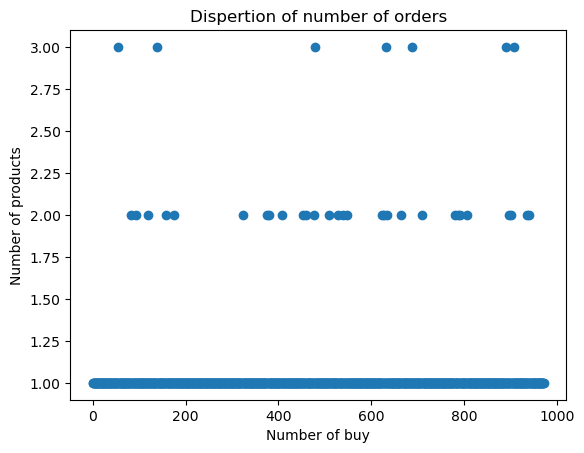

In [120]:
# Scatter plot
x_values = pd.Series(range(0, len(ordersByUsers['orders'])))
plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel('Number of buy')
plt.ylabel('Number of products')
plt.title('Dispertion of number of orders')
plt.show()

Hubo una compras atípicas, en promedio cada usuario compro 1 producto.

#### 6. Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [121]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


No más del 5% de los pedidos tienen mas de 1 procduto y sólo el 1% de los pedidos tienen 2 o más productos por pedido. Una compra de más de 1 producto es una compra anómala.

#### 7. Traza un gráfico de dispersión de los precios de los pedidos.

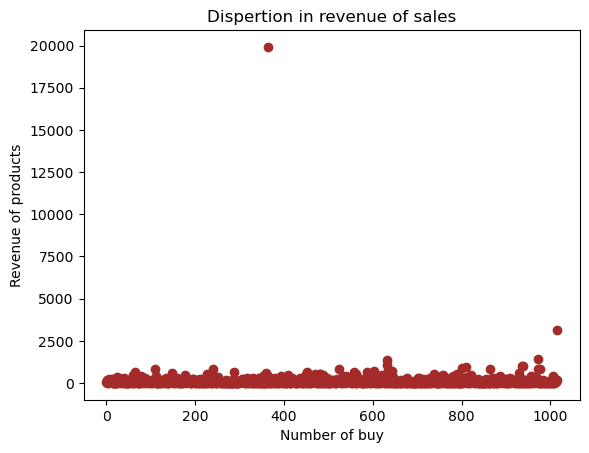

In [122]:
# Scatter plot
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='brown')
plt.xlabel('Number of buy')
plt.ylabel('Revenue of products')
plt.title('Dispertion in revenue of sales')
plt.show()

Se puede ver que hubo compras atípicas de mas de $1000.

#### 8. Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [123]:
print(np.percentile(orders['revenue'], [95, 99]))

[414.275 830.3  ]


No más del 5% de los pedidos cuestan más de 414 dolares y no más del 1% cuestan más de 830 dolares. Una compra mayor a $414 es una compra anómala.

#### 9. Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.

Se crearán 2 grupos.

In [124]:
# Group by 'userId' and count unique values of 'orderId' for group A
ordersByUsersA = orders[orders['group']=='A'].groupby('userId').agg({'orderId' : 'nunique'}).reset_index()
ordersByUsersA.columns = ['userId', 'orders']

#Group by 'userId' and count unique values of 'orderId' for group B
ordersByUsersB = orders[orders['group']=='B'].groupby('userId').agg({'orderId' : 'nunique'}).reset_index()
ordersByUsersB.columns = ['userId', 'orders']

Se crean 2 variables, sampleA y sampleB con usuarios de diferentes grupos y números de pedidos correspondientes. Los que no pidieron nada tendrán un 0. Esto es necesario para preparar las muestras para la prueba de Mann-Whitney.

In [125]:
# Contact 2 series
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
# Contact 2 series
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [126]:
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.160


La significancia estadística de la diferencia en la conversión entre los grupos es 16%. Relativamente alta.

#### 10. Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.

In [127]:
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.278


La significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos es de 27.8%, es relativamente grande, lo que implica hay diferencias entre los grupos.

#### 11. Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados.

Primero, se deben encontrar los usuarios anómalos.

In [128]:
# Contact 2 DataFrames by rows (axis=0)
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 1]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 1]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 414.275]['userId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

#Total of abnormal users
print(abnormalUsers.shape[0])

86


In [129]:
# Contact 2 DataFrames
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

In [130]:
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.174


La significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados es de 17%, es relativamente alta, igual que al usar los datos con anomalías.

#### 12. Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados.

In [131]:
# Obtain average income for group B
incomeB = orders[np.logical_and(orders['group']=='B',np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'].mean()

# Obtain average income for group B
incomeA = orders[np.logical_and(orders['group']=='A',np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'].mean()

#significance
print(incomeB / incomeA -1)

-0.03329650261005346


La significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos es de -3.32%, es baja, lo que implica que no hay diferencias entre los grupos al quitar compras anómalas.

### La prueba no paramétrica de Wilcoxon-Mann-Whitney

Cuando los datos tienen valores atípicos grandes (en comparación con la distribución normal), las métricas algebraicas no funcionan muy bien (media, mediana, suma). Un valor atípico puede desequilibrarlo todo. Por lo tanto, usará la prueba U de Mann-Whitney para muestras independientes con outliers, estas muestras se obtuvieron con una prueba A/B realizada previamente (no se muestra en este documento). Se usará un umbral de significación (alfa) del 5%.

**Hipótesis nula (H0):** Ganancias del grupo A < Ganancias del grupo B.

In [132]:
# Extract samples
sampleA = orders[orders['group']=='A']['revenue'].sort_values(ascending=True)
sampleB = orders[orders['group']=='B']['revenue'].sort_values(ascending=True)

In [133]:
# Umbral alpha for the Mann-Whitney U test
alpha = .05

# Mann-Whitney U test (it can also be: (sampleA, sampleB, True,'two-sided') )
results = st.mannwhitneyu(sampleA, sampleB, True,'less')
print('p-value: ', results.pvalue)

print("H0 is rejected" if results.pvalue < alpha else "H0 cannot be rejected:" + 
      "it is not possible to determine if there are significant differences between the two groups")

p-value:  0.5689678091666772
H0 cannot be rejected:it is not possible to determine if there are significant differences between the two groups


**Conclusion:** La hipótesis nula (H0) donde las ganancias del grupo A son menores a las ganancias del grupo B no puede ser rechazada, es decir, no existen diferencias significativas entre los grupos.

#### 13. Toma una decisión basada en los resultados de la prueba.

Del análisis anterior se mostró que exiten anomalías en las compras, estas anomalías distorcionan bastante los resultados, de manera que se observa una diferencia en el tamaño promedio de pedido entre los grupos A y B del 27%. Al quitar estas compras anómalas, la diferencia en el tamaño promedio de pedido entre los grupos es de -3.3%, lo que implica que no hay diferencia significativas entre los grupos.

Al observar las primeas gráficas de este documento (ingresos acumulados, tamaño de pedido promedio acumulado y diferencia relativa del tamaño de pedido promedio acumulado), se observa que el grupo B estuvo por encima del grupo A, en general, pero se debe a las compras anómalas.

La prueba U de Mann-Whitney mostró que no existen diferencias significativas entre los grupos.

Por lo tanto, se tomará la decisión de parar la prueba y concluir que no hay diferencia significativa entre los grupos.